![A soccer pitch for an international match.](soccer-pitch.jpg)

***Scenario:*** You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question we are trying to determine the answer to is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

In [1]:
import pandas as pd

# read data
df_men_socc = pd.read_csv('./data/men_results.csv')
df_women_socc = pd.read_csv('./data/women_results.csv')
# check the columns
print(df_men_socc.columns)
print(df_women_socc.columns)

Index(['Unnamed: 0', 'date', 'home_team', 'away_team', 'home_score',
       'away_score', 'tournament'],
      dtype='object')
Index(['Unnamed: 0', 'date', 'home_team', 'away_team', 'home_score',
       'away_score', 'tournament'],
      dtype='object')


In [2]:
# drop the redundant index column
df_men_socc.drop('Unnamed: 0', axis='columns', inplace=True)
df_women_socc.drop('Unnamed: 0', axis='columns', inplace=True)
# add gender column so we can combine
df_men_socc['gender'] = "men"
df_women_socc['gender'] = "women"
# combine
df_all = pd.concat([df_men_socc, df_women_socc], ignore_index=True)
print(f"shape BEFORE any filtering: {df_all.shape}")
df_all.head()

shape BEFORE any filtering: (49237, 7)


,date,home_team,away_team,home_score,away_score,tournament,gender
0,1872-11-30,Scotland,England,0,0,Friendly,men
1,1873-03-08,England,Scotland,4,2,Friendly,men
2,1874-03-07,Scotland,England,2,1,Friendly,men
3,1875-03-06,England,Scotland,2,2,Friendly,men
4,1876-03-04,Scotland,England,3,0,Friendly,men


In [3]:
# remove all rows before 2002-01-01
print(f"shape BEFORE removing matches before 2002-01-01: {df_all.shape}")
df_all = df_all.loc[df_all['date'] >= '2002-01-01'].copy()
print(f"shape AFTER removing matches before 2002-01-01: {df_all.shape}")
df_all.head()

shape BEFORE removing matches before 2002-01-01: (49237, 7)
shape AFTER removing matches before 2002-01-01: (23009, 7)


,date,home_team,away_team,home_score,away_score,tournament,gender
24863,2002-01-04,Bahrain,Finland,0,2,Prime Minister's Cup,men
24864,2002-01-04,Egypt,Ghana,2,0,Friendly,men
24865,2002-01-04,Martinique,Guadeloupe,1,3,Friendly,men
24866,2002-01-05,Albania,North Macedonia,0,0,Prime Minister's Cup,men
24867,2002-01-05,Kuwait,Zimbabwe,3,0,Friendly,men


## Remove qualifier matches

In [4]:
tournaments = df_all["tournament"].value_counts()
is_qual = tournaments.index.str.contains("qualification")
non_quals = tournaments[~is_qual]
# print(is_qual, '\n')
print(tournaments, '\n')
print(non_quals, '\n')
print(f"total count of tournament types BEFORE filtering: {len(tournaments)}")
print(f"total count of tournament types  AFTER filtering: {len(non_quals)} \n")

tournament
Friendly                                6936
FIFA World Cup qualification            4340
UEFA Euro qualification                 2149
African Cup of Nations qualification     968
FIFA World Cup                           584
                                        ... 
Copa América qualification                 2
Atlantic Heritage Cup                      2
Copa Confraternidad                        1
TIFOCO Tournament                          1
CONMEBOL–UEFA Cup of Champions             1
Name: count, Length: 100, dtype: int64 

tournament
Friendly                          6936
FIFA World Cup                     584
UEFA Nations League                468
Algarve Cup                        430
African Cup of Nations             405
                                  ... 
Copa Paz del Chaco                   2
Atlantic Heritage Cup                2
Copa Confraternidad                  1
TIFOCO Tournament                    1
CONMEBOL–UEFA Cup of Champions       1
Name: count, 

In [5]:
# remove all rows of qualification matches
print(f"shape BEFORE removing qualification matches: {df_all.shape}")
df_all = df_all.loc[df_all['tournament'].isin(non_quals.index)].copy()
print(f"shape AFTER removing qualification matches: {df_all.shape}")
df_all.head()

shape BEFORE removing qualification matches: (23009, 7)
shape AFTER removing qualification matches: (14060, 7)


,date,home_team,away_team,home_score,away_score,tournament,gender
24863,2002-01-04,Bahrain,Finland,0,2,Prime Minister's Cup,men
24864,2002-01-04,Egypt,Ghana,2,0,Friendly,men
24865,2002-01-04,Martinique,Guadeloupe,1,3,Friendly,men
24866,2002-01-05,Albania,North Macedonia,0,0,Prime Minister's Cup,men
24867,2002-01-05,Kuwait,Zimbabwe,3,0,Friendly,men


## Remove all non-FIFA matches

In [6]:
print(df_all["tournament"].value_counts()["FIFA World Cup"])  # 584
df_all_fifa = df_all[df_all['tournament'] == "FIFA World Cup"].copy()  # avoids SettingWithCopyWarning 2 cells down
print(df_all_fifa.shape)  # should be 584
df_all_fifa["gender"].value_counts()  # not horribly lopsided...

584
(584, 7)


gender
men      384
women    200
Name: count, dtype: int64

In [7]:
# add column of total goals scored needed for comparison
df_all_fifa["total_goals"] = df_all_fifa['home_score'] + df_all_fifa['away_score']

print(df_all_fifa[df_all_fifa["gender"] == "men"].describe(), '\n')    # 384
print(df_all_fifa[df_all_fifa["gender"] == "women"].describe(), '\n')  # 200

# df_all_fifa.to_csv("./data/df_fifa.csv")

df_all_fifa.head()

       home_score  away_score  total_goals
count  384.000000  384.000000   384.000000
mean     1.375000    1.138021     2.513021
std      1.328538    1.107398     1.652544
min      0.000000    0.000000     0.000000
25%      0.000000    0.000000     1.000000
50%      1.000000    1.000000     2.000000
75%      2.000000    2.000000     3.000000
max      8.000000    7.000000     8.000000 

       home_score  away_score  total_goals
count  200.000000  200.000000   200.000000
mean     1.805000    1.175000     2.980000
std      1.937977    1.289453     2.022387
min      0.000000    0.000000     0.000000
25%      1.000000    0.000000     2.000000
50%      1.000000    1.000000     3.000000
75%      2.000000    2.000000     4.000000
max     13.000000    7.000000    13.000000 



,date,home_team,away_team,home_score,away_score,tournament,gender,total_goals
25164,2002-05-31,France,Senegal,0,1,FIFA World Cup,men,1
25165,2002-06-01,Germany,Saudi Arabia,8,0,FIFA World Cup,men,8
25166,2002-06-01,Republic of Ireland,Cameroon,1,1,FIFA World Cup,men,2
25167,2002-06-01,Uruguay,Denmark,1,2,FIFA World Cup,men,3
25168,2002-06-02,Argentina,Nigeria,1,0,FIFA World Cup,men,1


## Goal distributions

Before selecting a test to test our hypothesis, let's looks at the shape of the total goals distributions. It is not obvious from the visual below that women matches score more goals on average. We can also see that these distributions clearly are **not** normal which we knew in advance to be the case because it is a discrete distribution with the left side being bounded by zero (i.e. can not go below zero).

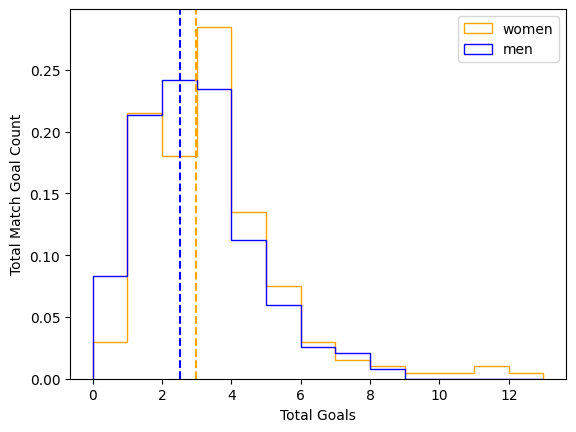

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

goal_bins = range(14)
men_mean = df_all_fifa[df_all_fifa['gender'] == 'men']['total_goals'].mean()
women_mean = df_all_fifa[df_all_fifa['gender'] == 'women']['total_goals'].mean()

fig, ax = plt.subplots()
ax.hist(df_all_fifa[df_all_fifa['gender'] == 'women']['total_goals'],
        label="women", bins=goal_bins, histtype="step", density=True, color='orange')
ax.hist(df_all_fifa[df_all_fifa['gender'] == 'men']['total_goals'],
        label="men", bins=goal_bins, histtype="step", density=True, color='blue')
ax.set_xlabel("Total Goals")
ax.set_ylabel("Total Match Goal Count")
ax.legend()
plt.axvline(x=men_mean, color='blue', linestyle='--')     # men mean
plt.axvline(x=women_mean, color='orange', linestyle='--') # women mean

plt.show()

## Difference distribution

What we are really after is whether or not women's matches score more goals than men's matches. Since the data is not paired, we can create pairs of all the combinations of women and men's matches with a Cartesian product, generate the distribution of differences and use that distribution to test the null hypothesis against the altenative. This is somewhat computationally expensive, but is not too back because we are dealing with a relatively small number of matches.

A less computationally expensive approach would be to create a bootstrap distribution of these differences. We'll do both and compare the results.

The above results imply that we should fail to reject $H_0$. Let's see if we get the same results if we create a bootstrap distribution of the differences between men and women's matches.

In [9]:
total_men_women_match_combinations = 384 * 200
print(f"total (men, women) match combinations: {total_men_women_match_combinations}")

total (men, women) match combinations: 76800


76800
76800


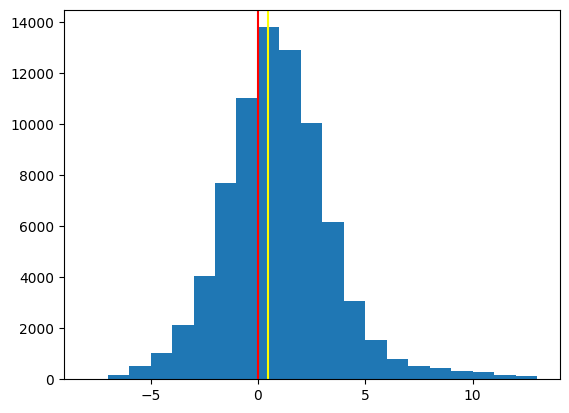

In [10]:
import itertools
import numpy as np
# Cartesian product of all men and women matches
total_women_men_match_scores = tuple(
    itertools.product(
        df_all_fifa[df_all_fifa["gender"] == "women"]['total_goals'],
        df_all_fifa[df_all_fifa["gender"] == "men"]['total_goals']
    )
)

score_diffs = [x[0] - x[1] for x in total_women_men_match_scores]

bin_intervals = list(range(min(score_diffs), max(score_diffs)+1))

print(len(total_women_men_match_scores))  # should be 76800, check
print(len(score_diffs))                   # should be 76800, check

# What does the distribution of these diff look like?
fig, ax = plt.subplots()
ax.hist(score_diffs,
        label="score diffs",
        bins=bin_intervals)
# add reference lines
act_mean_cart = np.mean(score_diffs)
plt.axvline(x=act_mean_cart, color='yellow')  # actual mean
plt.axvline(x=0, color='red')            # hypothesized mean
plt.show()

The above distribution is clearly shifted to the right of 0, but it is not clear whether the yellow line is significantly different from the red line.

In [11]:
from scipy.stats import norm

hyp_mean = 0
std_error_cart = np.std(score_diffs, ddof=1)
z_score_cart = (act_mean_cart - hyp_mean) / std_error_cart
p_value_cart = 1 - norm.cdf(z_score_cart, loc=0, scale=1)  # HA: women goals > men goals
print(f"mean of cartesian product diffs = {act_mean_cart}, std error = {std_error_cart} | z score = {z_score_cart} | p-value = {p_value_cart}")

mean of cartesian product diffs = 0.46697916666666667, std error = 2.6064299814051477 | z score = 0.17916428601504744 | p-value = 0.4289043527857148


## The z-test implies rejecting the null hypothesis

The above results imply that we should fail to reject $H_0$ in favor of $H_A$. Let's see if we get the same results if we create a bootstrap distribution of the differences between men and women's matches.

In [12]:
goals_women = df_all_fifa[df_all_fifa["gender"] == "women"]['total_goals']
goals_men = df_all_fifa[df_all_fifa["gender"] == "men"]['total_goals']

print(type(goals_women), type(goals_men), len(goals_women), len(goals_men))
print(goals_women.describe(), '\n')
print(goals_men.describe(), '\n')

sample_diffs = []
goals_women.head()
for i in range(10000):
    sample_women = goals_women.sample(n=1, replace=True).values[0]
    sample_men = goals_men.sample(n=1, replace=True).values[0]
    sample_diffs.append(sample_women - sample_men)

# print(sample_diffs)

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> 200 384
count    200.000000
mean       2.980000
std        2.022387
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       13.000000
Name: total_goals, dtype: float64 

count    384.000000
mean       2.513021
std        1.652544
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        8.000000
Name: total_goals, dtype: float64 



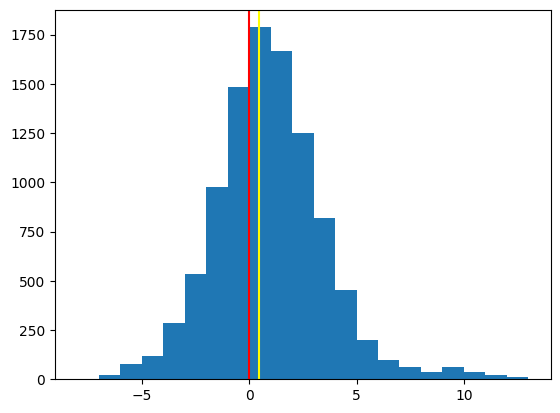

In [13]:
# What does the bootstrap distribution of these diff look like?
fig, ax = plt.subplots()
ax.hist(sample_diffs,
        label="bootstap_score_diffs",
        bins=bin_intervals)
# add reference lines
act_mean_boot = np.mean(sample_diffs)
plt.axvline(x=act_mean_boot, color='yellow')  # actual mean
plt.axvline(x=0, color='red')                 # hypothesized mean
plt.show()

### Bootstrap distribution of diff's look almost identical to the distribution of diff's generated from the Cartesian product of all men and women FIFA matches

The z-test on this distribution give almost idential results as shown below.

In [14]:
hyp_mean = 0
std_error_boot = np.std(sample_diffs, ddof=1)
z_score_boot = (act_mean_boot - hyp_mean) / std_error_boot
p_value_boot = 1 - norm.cdf(z_score_boot, loc=0, scale=1)  # HA: women goals > men goals
print(f"mean of bootstrap diffs = {act_mean_boot}, std error = {std_error_boot} | z score = {z_score_boot} | p-value = {p_value_boot}")

mean of bootstrap diffs = 0.4661, std error = 2.6036759980593374 | z score = 0.179016129636487 | p-value = 0.4289625183291652


## Comparing distributions

The distribution of differences constructed from the Cartesian product of all women and men's matches looks very similar to a 10000-sample bootstrap distribution of differences. Of note, the later used roughly 8x less samples (76800 vs 1,000)

In [15]:
alpha = 0.10

def test_hypothesis(alpha, p_val):
    """ Evaluates a test of a hypothesis

    Args:
      alpha (float): significance level of the hypothesis test
      p_val (float): probability that the null hypothesis is true
    
    """
    if p_val < alpha:
        result = "reject"
    else:
        result = "fail to reject"

    return {"p_val": p_val, "result": result}

In [16]:
result_dict = test_hypothesis(alpha, p_value_cart)

print(f"z-score test p-value: {result_dict['p_val']}")
print(f"At alpha = {alpha}, we {result_dict['result']} the null hypothesis that means are the same in favor of the alternative hypothesis")

z-score test p-value: 0.4289043527857148
At alpha = 0.1, we fail to reject the null hypothesis that means are the same in favor of the alternative hypothesis


## Mann-Whitney U rank test

Since the distibution of goals in FIFA matches is not normal (because it's Poisson), we should run a non-parametric test such as the *Mann-Whitney U rank test*.

In [18]:
from scipy.stats import mannwhitneyu

alpha = 0.10

stat, p_val_mannwh = mannwhitneyu(
    df_all_fifa[df_all_fifa['gender'] == 'women']['total_goals'],
    df_all_fifa[df_all_fifa['gender'] == 'men']['total_goals'],
    alternative='greater'  # HA: women score more goals
)

def test_hypothesis(alpha, p_val):
    if p_val < alpha:
        result = "reject"
    else:
        result = "fail to reject"

    return {"p_val": p_val, "result": result}

result_dict = test_hypothesis(alpha, p_val_mannwh)

print(f"Mann-Whitney U test p-value: {result_dict['p_val']}")
print(f"At alpha = {alpha}, we {result_dict['result']} the null hypothesis that means are the same in favor of the alternative hypothesis")

Mann-Whitney U test p-value: 0.005106609825443641
At alpha = 0.1, we reject the null hypothesis that means are the same in favor of the alternative hypothesis


## Open question...

Why does constructing a distribution of differences from the Cartesian product of all matches and doing a z-test on this distribution give different results from a *Mann-Whitney U rank test*?